# 📰 Analyse des actualités agricoles de l'Agence Ecofin

Ce notebook a pour objectif de scraper des articles liés à la régulation des exportations agricoles dans les pays d’Afrique de l’Ouest, extraits du site [agenceecofin.com](https://www.agenceecofin.com/actualites-agro), puis d'extraire les données pertinentes et les sauvegarder dans un fichier Excel.

In [4]:
#!python -m spacy download fr_core_news_sm


In [26]:
import requests
from bs4 import BeautifulSoup
import re
import time
import pandas as pd
import spacy
from tqdm import tqdm

In [6]:
# Charger le modèle de langue français de spaCy
nlp = spacy.load("fr_core_news_sm")

In [7]:
# Initialisation des variables
mois_francais = {
    'janvier': '01', 'février': '02', 'fevrier': '02', 'mars': '03',
    'avril': '04', 'mai': '05', 'juin': '06',
    'juillet': '07', 'août': '08', 'aout': '08', 'septembre': '09',
    'octobre': '10', 'novembre': '11', 'décembre': '12', 'decembre': '12'
}

countries = ["Bénin", "Burkina Faso", "Cap-Vert", "Côte d'Ivoire", "Gambie", "Ghana", "Guinée",
             "Guinée-Bissau", "Libéria", "Mali", "Niger", "Nigéria", "Sénégal", "Sierra Leone", "Togo"]

keywords = [
    "interdiction des exportations agricoles", "licences d'exportation",
    "embargo sur les exportations agricoles", "limitation des exportations agricole",
    "exportation produits vivriers", "régulation", "suspension des exportations agricoles",
    "gouvernement suspend ", "restriction des exportations agricoles",
    "interdiction des exportations", "blocage", "plafonnement", "mesures protectionnistes",
    "interdiction exportation arachides", "produits agricoles exportés", "céréales",
    "blé", "riz", "maïs", "acajou", "amande karité", "fruits et légumes", "produits vivriers",
    "produits de rente", "pénurie", "tubercules", "niébé", "sorgho", "soja"
]

produits = ["maïs", "riz", "blé", "niébé", "sorgho", "soja", "cajou", "karité", "arachide", "mil", "tubercules"]

In [8]:
# Lemmatisation des mots-clés
keywords_lemmatized = []
for phrase in keywords:
    doc = nlp(phrase.lower())
    keywords_lemmatized.append(" ".join([token.lemma_ for token in doc]))

In [9]:
# Fonction de normalisation de texte
def normalize(text):
    return text.lower().strip()

In [30]:
from concurrent.futures import ThreadPoolExecutor, as_completed


base_url = 'https://www.agenceecofin.com/actualites-agro'
data = []
article_tasks = []

def normalize(text):
    return text.lower().strip()


# ----------- Étape 1 : collecter les liens des articles pertinents -----------
for page in tqdm(range(0, 1000, 10), desc="Collecte des liens"):
    try:
        url = f'{base_url}?limitstart={page}'
        response = requests.get(url, timeout=20)
        if response.status_code != 200:
            continue
        soup = BeautifulSoup(response.text, 'lxml')
        articles = soup.find_all('div', class_='catItemHeader')

        for article in articles:
            title_tag = article.find('div', class_='catItemTitle')
            if not title_tag:
                continue
            title = title_tag.text.strip()

            if (any(c.lower() in title.lower() for c in countries) and
                any(k.lower() in title.lower() for k in keywords)):
               
                country = next((c for c in countries if c.lower() in title.lower()), "Inconnu")
                more_info = article.a['href']
                full_url = f'https://www.agenceecofin.com{more_info}'
                article_tasks.append((title, full_url, country))
    except Exception as e:
        print(f"Erreur page {page}: {e}")
        continue

# ----------- Étape 2 : fonction pour traiter un article -----------
def process_article(title, url_article, country):
    try:
        html_text2 = requests.get(url_article, timeout=20).text
        soup2 = BeautifulSoup(html_text2, 'lxml')
        read = soup2.find_all('div', class_='itemIntroText')

        published_date = soup2.find('span', class_='itemDateCreated')
        if published_date:
            published_date = published_date.text.strip()
            match = re.search(r'(\d{1,2})\s+(\w+)\s+(\d{4})', published_date.lower())
            if match:
                mois_nom = match.group(2)
                annee = match.group(3)
                mois_num = mois_francais.get(mois_nom)
                published_date = f'{mois_num}-{annee}' if mois_num else "Date inconnue"
            else:
                published_date = "Date inconnue"
        else:
            published_date = "Date inconnue"

        texte_complet = " ".join([normalize(p.text.strip()) for p in read])
        texte_final = re.split(r"lire\\s+aussi[:\\s]*", texte_complet, flags=re.IGNORECASE)[0].strip()
        texte_final = re.sub(r"\\bmillions?\\b|\\bmilliards?\\b|\\bmilliers?\\b|\\bmilieu?\\b", "", texte_final, flags=re.IGNORECASE)
        texte_final = re.sub(r"\\s{2,}", " ", texte_final).strip()

        produits_trouves = [produit for produit in produits if normalize(produit) in texte_final]
        produits_uniques = list(set(produits_trouves))

        return {
            "pays": country,
            "title": title,
            "date": published_date,
            "article": texte_final,
            "produits": ", ".join(produits_uniques)
        }

    except Exception as e:
        print(f"Erreur article {url_article}: {e}")
        return None

# ----------- Étape 3 : traitement en parallèle avec ThreadPoolExecutor -----------
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [
        executor.submit(process_article, title, url, country)
        for title, url, country in article_tasks
    ]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Traitement articles"):
        result = future.result()
        if result:
            data.append(result)


Traitement articles: 100%|█████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  3.87it/s]


In [31]:
# Conversion en DataFrame et aperçu
df = pd.DataFrame(data)
df.head()

,pays,title,date,article,produits
0,Burkina Faso,Burkina Faso : exonération de taxes sur la pro...,09-2024,"(agence ecofin) - au burkina faso, les céréale...","blé, maïs, sorgho, karité, mil"
1,Togo,Togo : croissance consécutive de la production...,04-2024,(agence ecofin) - le togo applique une politiq...,"riz, sorgho, maïs, mil"
2,Niger,Le Nigeria discute avec l’Arabie saoudite pour...,07-2024,(agence ecofin) - le nigeria dispose d’un gran...,"soja, mil"
3,Bénin,Le Bénin interdit l’exportation de produits vi...,05-2024,"(agence ecofin) - au bénin, le maïs est la pri...","tubercules, maïs, riz, niébé, mil"
4,Guinée,Guinée-Bissau : le gouvernement veut mettre un...,04-2024,(agence ecofin) - le riz est l’une des princip...,"riz, mil"


In [32]:
df.tail()

,pays,title,date,article,produits
18,Ghana,Guinness Ghana Breweries et SNV lancent un pla...,06-2023,"(agence ecofin) - au ghana, le sorgho est la t...","riz, sorgho, maïs, mil"
19,Sierra Leone,Sierra Leone : la FAO et le Vietnam s’associen...,06-2023,"(agence ecofin) - en sierra leone, le riz est ...","riz, blé, mil"
20,Niger,Nigeria : Port Harcourt abritera un hub pour l...,03-2023,(agence ecofin) - le nigeria est le principal ...,"riz, blé, mil"
21,Niger,"Nigeria : FMN obtient 1,2 million $ pour accro...",12-2022,"(agence ecofin) - au nigeria, la demande crois...","soja, blé, maïs, mil"
22,Ghana,"Ghana : avec près de 368 000 tonnes, la produc...",06-2023,"(agence ecofin) - en afrique de l’ouest, les l...","riz, niébé, mil"


In [15]:
# Export en Excel
df.to_excel("articles_ecofin.xlsx", index=False)

## 📊 Visualisation des données collectées

Voyons maintenant quelques statistiques de base sur les articles collectés :

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Configuration de style
sns.set(style="whitegrid")

### Nombre d'articles par pays

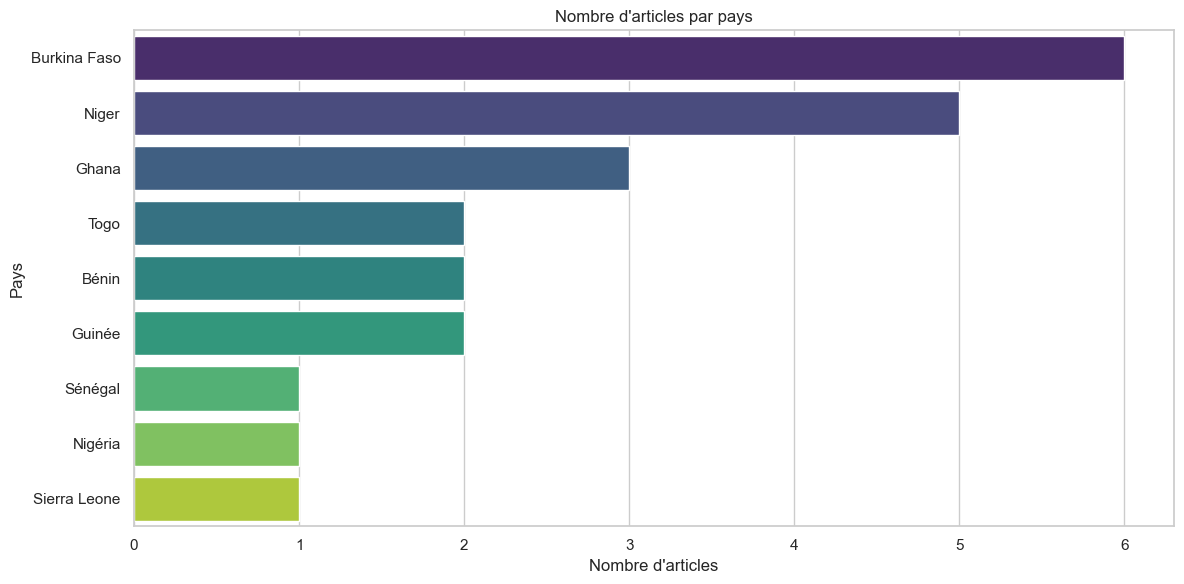

In [33]:
plt.figure(figsize=(12,6))
article_counts = df['pays'].value_counts().sort_values(ascending=False)
sns.barplot(x=article_counts.values, y=article_counts.index, palette="viridis")
plt.title("Nombre d'articles par pays")
plt.xlabel("Nombre d'articles")
plt.ylabel("Pays")
plt.tight_layout()
plt.show()

### Répartition des produits agricoles mentionnés

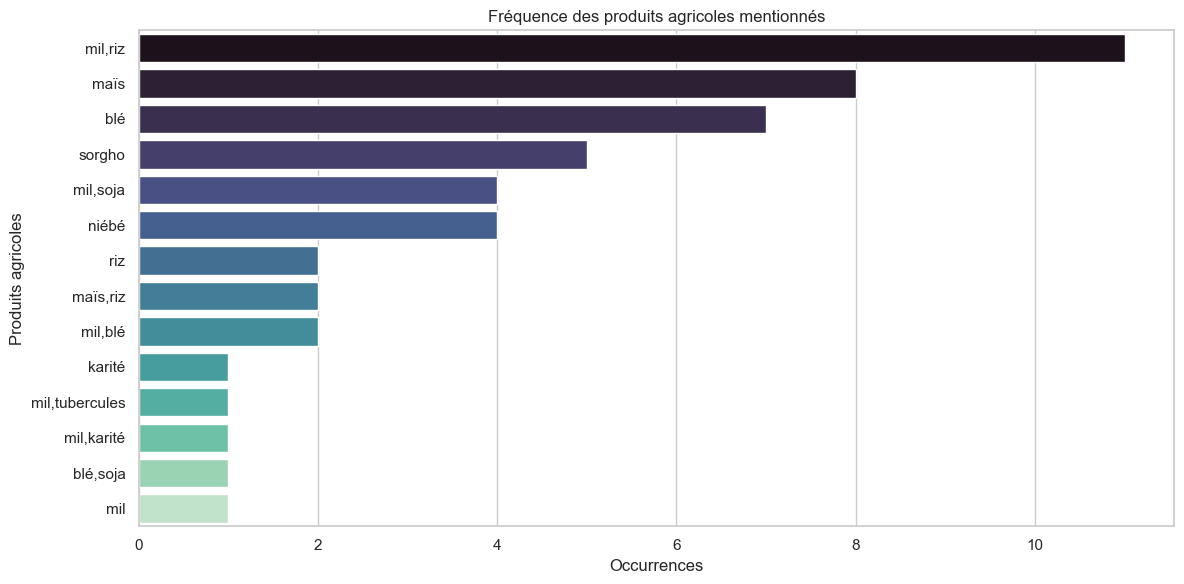

In [34]:
from collections import Counter
produit_list = ",".join(df['produits'].dropna()).split(", ")
produit_counts = Counter(produit_list)
produit_df = pd.DataFrame.from_dict(produit_counts, orient='index', columns=['count'])
produit_df = produit_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=produit_df['count'], y=produit_df.index, palette="mako")
plt.title("Fréquence des produits agricoles mentionnés")
plt.xlabel("Occurrences")
plt.ylabel("Produits agricoles")
plt.tight_layout()
plt.show()

### Nombre d'articles par année

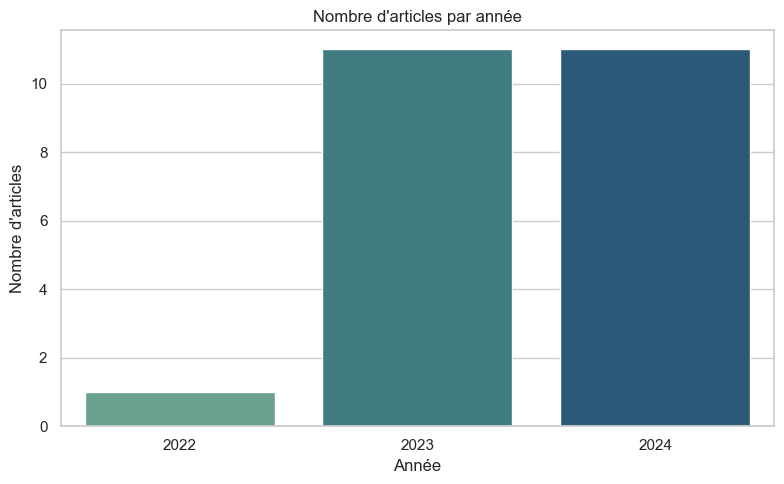

In [35]:
# Extraire l'année de la colonne 'date' au format MM-YYYY
df['année'] = df['date'].apply(lambda x: x.split('-')[1] if '-' in x else None)
year_counts = df['année'].value_counts().sort_index()

plt.figure(figsize=(8,5))
sns.barplot(x=year_counts.index, y=year_counts.values, palette="crest")
plt.title("Nombre d'articles par année")
plt.xlabel("Année")
plt.ylabel("Nombre d'articles")
plt.tight_layout()
plt.show()